<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/4_5_3_Inception_V3_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics pandas torchviz

# **실습 3 : Inception V3 Model Fine Tuning**

## **Import Module**

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
#from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning.loggers import CSVLogger
import torchvision
import torchvision.transforms as transforms
from torchmetrics import functional as FM
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from IPython import display
plt.rcParams['figure.figsize'] = [5, 3.5]

device ='cuda:0'
torch.__version__

'2.0.1+cu118'

## **Dataset Load**

In [ ]:
from torchvision.datasets.utils import download_and_extract_archive
import pathlib

dataset_url = \
      "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
root = './'
data_dir='Dataset'
download_and_extract_archive(dataset_url, root, data_dir)
data_dir = root+data_dir+'/flower_photos/'
data_dir = pathlib.Path(data_dir)
data_dir

100%|██████████| 228813984/228813984 [00:06<00:00, 37393978.39it/s]


Extracting ./flower_photos.tgz to Dataset


PosixPath('Dataset/flower_photos')

In [ ]:
!ls {data_dir}

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


##### Check Images

In [ ]:
# 지정 폴더 아래에 있는 모든 *.jpg 파일의 수
#  및 폴더명 목록을 리턴
def check_dir(d_path):
    img_count = len(list(d_path.glob('*/*.jpg')))
    c_name = np.array([item.name for item in d_path.glob('*') if item.name != "LICENSE.txt"])
    return img_count, c_name, len(c_name)

# check_dir()로 폴더명과 이미지 숫자 확인
image_count, CLASS_name, class_num = check_dir(data_dir)
CLASS_name.sort()
print('Train image_count: {}\nclasses: {}'.format(image_count, CLASS_name))

Train image_count: 3670
classes: ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [ ]:
# 지정 path 아래에 있는 폴더에서 이미지 두장씩을 확인
def check_image(d_path, class_list):
    for i in range(len(class_list)):
        class_temp = list(d_path.glob(str(class_list[i])+'/*'))
        for image_path in class_temp[:2]:
            display.display(Image.open(str(image_path)))
# check_image()로 이미지 두장씩 확인
check_image(data_dir, CLASS_name)

#### ImageFolder, DataLoader 적용

In [ ]:
# Imagae size 결정 **
IN_IMG_SIZE = 299
batch_n = 64 ## 32

In [ ]:
from torchvision.transforms.autoaugment import AutoAugment
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

## loader에 적용할 transform
_transforms = transforms.Compose([transforms.Resize((IN_IMG_SIZE, IN_IMG_SIZE)),
#                               transforms.RandomResizedCrop(IN_IMG_SIZE, scale=[0.8, 1.0]),
                               transforms.RandomHorizontalFlip(0.5),
                               transforms.ToTensor()])

## ImageFolder : folder로 구성된 image set을 위한 loader
imgs = ImageFolder(data_dir, transform=_transforms) #(image,label)

len(imgs)

3670

##### Train / Test Data split

In [ ]:
import torch.utils.data as data

train_set_size = int(len(imgs) * 0.7)
valid_set_size = len(imgs) - train_set_size

# split the train set into two
train_set, valid_set = data.random_split(imgs, [train_set_size, valid_set_size])

print(train_set_size,valid_set_size)

2569 1101


In [ ]:
## DataLoader : dataset과 sampler를 결합 batch단위 제공 #(image,label)*batch
train_loader = DataLoader(train_set, batch_size=batch_n, shuffle=True,num_workers=4)
val_loader = DataLoader(valid_set, batch_size=batch_n, shuffle=False,num_workers=4)

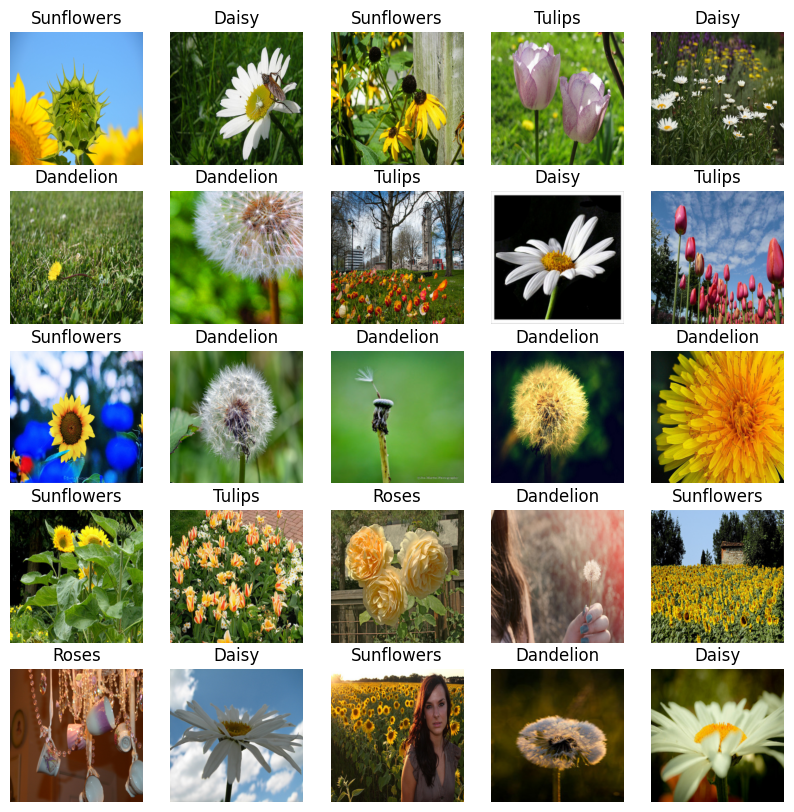

In [ ]:
def show_batch(data_gen, class_l):
    # get image and label from data generator
    img_batch, l_batch = next(iter(data_gen))
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(img_batch[n].permute(1, 2, 0))
        plt.title(class_l[l_batch[n]].title())
        plt.axis('off')
    return img_batch, l_batch

# check dataset
_,_ = show_batch(train_loader, CLASS_name)
#_,_ = show_batch(vla_loader, CLASS_test)

## **Load InceptionV3 model**
https://pytorch.org/hub/pytorch_vision_inception_v3/

In [ ]:
InceptionV3 = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 235MB/s] 


In [ ]:
input_shape=(batch_n, 3, IN_IMG_SIZE, IN_IMG_SIZE)
summary(InceptionV3, input_size=input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
Inception3                               [64, 1000]                3,326,696
├─BasicConv2d: 1-1                       [64, 32, 149, 149]        --
│    └─Conv2d: 2-1                       [64, 32, 149, 149]        864
│    └─BatchNorm2d: 2-2                  [64, 32, 149, 149]        64
├─BasicConv2d: 1-2                       [64, 32, 147, 147]        --
│    └─Conv2d: 2-3                       [64, 32, 147, 147]        9,216
│    └─BatchNorm2d: 2-4                  [64, 32, 147, 147]        64
├─BasicConv2d: 1-3                       [64, 64, 147, 147]        --
│    └─Conv2d: 2-5                       [64, 64, 147, 147]        18,432
│    └─BatchNorm2d: 2-6                  [64, 64, 147, 147]        128
├─MaxPool2d: 1-4                         [64, 64, 73, 73]          --
├─BasicConv2d: 1-5                       [64, 80, 73, 73]          --
│    └─Conv2d: 2-7                       [64, 80, 73, 73]          5,

In [ ]:
InceptionV3

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
InceptionV3.fc = nn.Sequential(
#                            nn.Linear(2048,512),
#                            nn.Dropout(0.5),
                            nn.Linear(2048, class_num)
                          )
InceptionV3

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
#torch.onnx.export(InceptionV3, torch.zeros(batch_n, 3, IN_IMG_SIZE, IN_IMG_SIZE).to(device), 'inceptionV3.onnx')

### **마지막 `Inception module`만 남기고 나머지는 전부 freeze**
- ### 마지막 conv layer가 fine tuning 됨


In [ ]:
for i, (name,child_module) in enumerate(InceptionV3.named_children()):
  if name == 'Mixed_7c':
    break
  else :
    print(i,':',name,'freezed')
    for param in child_module.parameters():
            param.requires_grad = False

0 : Conv2d_1a_3x3 freezed
1 : Conv2d_2a_3x3 freezed
2 : Conv2d_2b_3x3 freezed
3 : maxpool1 freezed
4 : Conv2d_3b_1x1 freezed
5 : Conv2d_4a_3x3 freezed
6 : maxpool2 freezed
7 : Mixed_5b freezed
8 : Mixed_5c freezed
9 : Mixed_5d freezed
10 : Mixed_6a freezed
11 : Mixed_6b freezed
12 : Mixed_6c freezed
13 : Mixed_6d freezed
14 : Mixed_6e freezed
15 : AuxLogits freezed
16 : Mixed_7a freezed
17 : Mixed_7b freezed


In [ ]:
for child in InceptionV3.children():
    for param in child.parameters():
        print(child.__class__, param.requires_grad)

<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.BasicConv2d'> False
<class 'torchvision.models.inception.InceptionA'> False
<class 'torchvision.models.inception.InceptionA'> False
<class 'torchvision.models.incept

## FineTune Model

In [ ]:
import torchvision.models as models
import pdb

loss_function = nn.CrossEntropyLoss()

class InceptionFineTune(pl.LightningModule):
    def __init__(self, inceptionv3):
        super(InceptionFineTune, self).__init__()
        self.features = inceptionv3

    def forward(self, x):
        x = self.features(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        # InceptionOutputs은 결과 tensor값을 logits이란 변수로 가짐
        loss = loss_function(y_pred.logits, y)
        acc = FM.accuracy(y_pred.logits, y, task='multiclass', num_classes=5)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics,prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task='multiclass', num_classes=5)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics, prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001) ###

inceptionFineTune = InceptionFineTune(InceptionV3)
summary(inceptionFineTune, input_size=(batch_n, 3, IN_IMG_SIZE, IN_IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
InceptionFineTune                        [64, 5]                   --
├─Inception3: 1-1                        [64, 5]                   3,326,696
│    └─BasicConv2d: 2-1                  [64, 32, 149, 149]        --
│    │    └─Conv2d: 3-1                  [64, 32, 149, 149]        (864)
│    │    └─BatchNorm2d: 3-2             [64, 32, 149, 149]        (64)
│    └─BasicConv2d: 2-2                  [64, 32, 147, 147]        --
│    │    └─Conv2d: 3-3                  [64, 32, 147, 147]        (9,216)
│    │    └─BatchNorm2d: 3-4             [64, 32, 147, 147]        (64)
│    └─BasicConv2d: 2-3                  [64, 64, 147, 147]        --
│    │    └─Conv2d: 3-5                  [64, 64, 147, 147]        (18,432)
│    │    └─BatchNorm2d: 3-6             [64, 64, 147, 147]        (128)
│    └─MaxPool2d: 2-4                    [64, 64, 73, 73]          --
│    └─BasicConv2d: 2-5                  [64, 80, 73, 73]

In [ ]:
from pytorch_lightning.callbacks import ModelSummary

# trainer = Trainer(max_epochs=1,callbacks=[ModelSummary(max_depth=2)],accelerator='auto')
# trainer.fit(inceptionFineTune, train_loader, val_dataloaders=val_loader)

## **Fit**

In [ ]:
%%time
inceptionFineTune = InceptionFineTune(InceptionV3)

epochs=5
logger = CSVLogger("logs", name="InceptionFineTune")
trainer = Trainer(max_epochs=epochs, logger=logger, accelerator='auto')
trainer.fit(inceptionFineTune, train_loader, val_dataloaders=val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params
----------------------------------------
0 | features | Inception3 | 25.1 M
----------------------------------------
6.1 M     Trainable params
19.0 M    Non-trainable params
25.1 M    Total params
100.490   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (41) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


CPU times: user 1min 13s, sys: 6.85 s, total: 1min 20s
Wall time: 1min 37s


Wall time: 1min 37s

## **Analysis**

In [ ]:
v_num = logger.version

history = pd.read_csv(f'./logs/InceptionFineTune/version_{v_num}/metrics.csv')
history_plot = history.drop('step', axis=1).groupby('epoch').last()
print('\t',np.max(history_plot['val_acc']))

	 0.9173478484153748


 0.9836512207984924


In [ ]:
history_plot

,val_loss,val_acc,loss,acc
epoch,,,,
0,0.429141,0.878292,0.832613,0.739198
1,0.305771,0.896458,0.324419,0.911250
2,0.267221,0.908265,0.209063,0.946283
3,0.251030,0.914623,0.146546,0.964967
4,0.245362,0.917348,0.090169,0.981316


0.9173478484153748


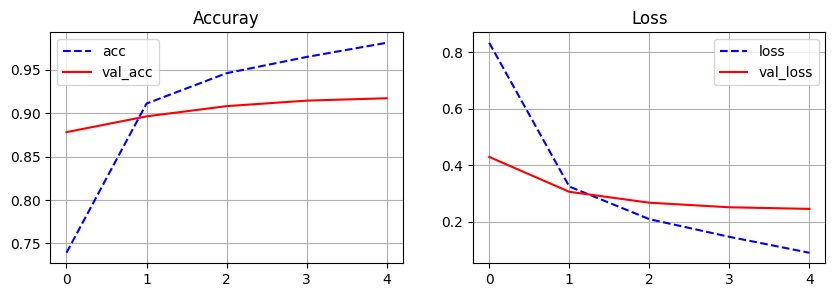

In [ ]:
history = history_plot

print(np.max(history['val_acc']))

plt.figure(figsize=(10, 3.))
plt.subplot(121)
plt.title('Accuray')
plt.plot( history['acc'], 'b--', label='acc')
plt.plot( history['val_acc'], 'r', label='val_acc')
plt.grid()
#    plt.ylim([0.6, 1])
plt.legend()

plt.subplot(122)
plt.title('Loss')
plt.plot( history['loss'], 'b--', label='loss')
plt.plot( history['val_loss'], 'r', label='val_loss')
plt.grid()
#plt.ylim([0.0, 0.6])
plt.legend()
plt.show()

0.9863760471343994
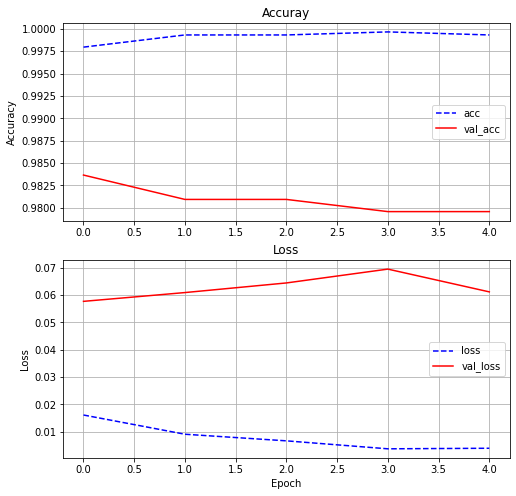

```python
InceptionV3.fc = nn.Sequential(
                            nn.Linear(2048,512),
                            nn.Dropout(0.5),
                            nn.Linear(512, class_num)
                          )
```

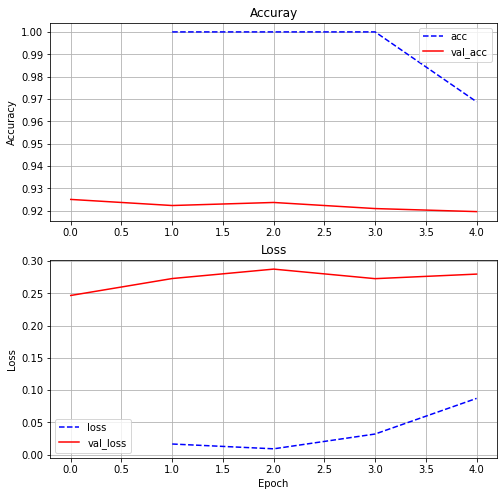

```python
InceptionV3.fc = nn.Linear(512, class_num)
```

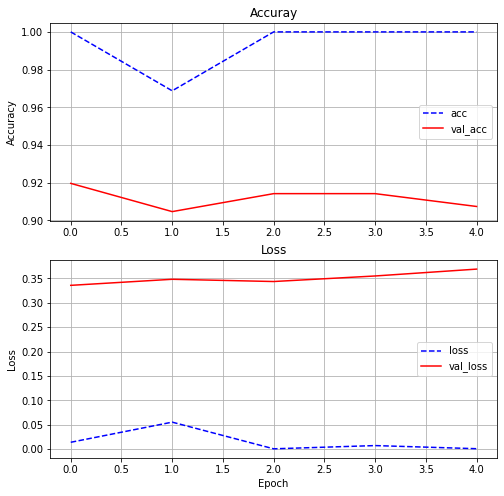

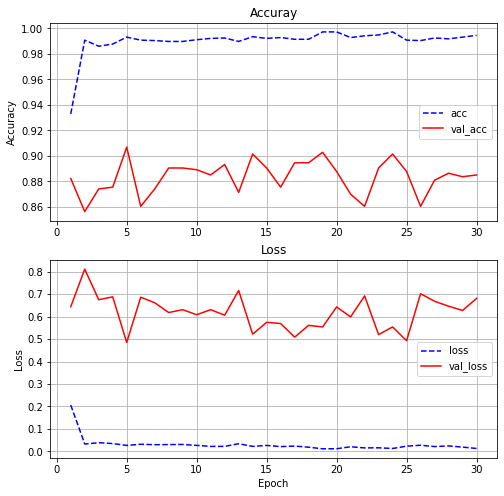

## **실습 과제**

### **마지막 inception module을 학습하도록 남겨놓을 필요가 있을까?**
#### -- 마지막까지 freeze한 경우에 성능은 어떨까 학인해 보자
#### -- 모델전체를 freeze하지 않고 학습시키면 어떤 결과를 얻을 수 있를까 확인해 보자


In [ ]:
## 문제점 빠르게 확인하기
trainer = Trainer(max_epochs=3,
                  limit_train_batches=0.1,
                  limit_val_batches=0.1, accelerator='auto')
trainer.fit(inceptionFineTune, train_loader, val_dataloaders=val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params
----------------------------------------
0 | features | Inception3 | 25.1 M
----------------------------------------
6.1 M     Trainable params
19.0 M    Non-trainable params
25.1 M    Total params
100.490   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.
